In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
data = pd.read_csv("mock_kaggle.csv")

In [4]:
data.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [5]:
data.columns = ['date','Sales','Stock','price']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    937 non-null    object 
 1   Sales   937 non-null    int64  
 2   Stock   937 non-null    int64  
 3   price   937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [7]:
data['date'] = pd.to_datetime(data['date'])

In [8]:
data.head()

,date,Sales,Stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [9]:
df = data[['date','Sales']]

In [10]:
df.set_index('date',inplace=True)

In [11]:
df = df.asfreq('D')
df = df.fillna(method='ffill').astype(float)

/var/folders/1y/t6t0l6wj4dq7t57y367jf89c0000gn/T/ipykernel_89788/384730238.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').astype(float)


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,943.0,90.492047,80.469137,0.0,33.5,76.0,127.0,542.0


<Axes: xlabel='date'>

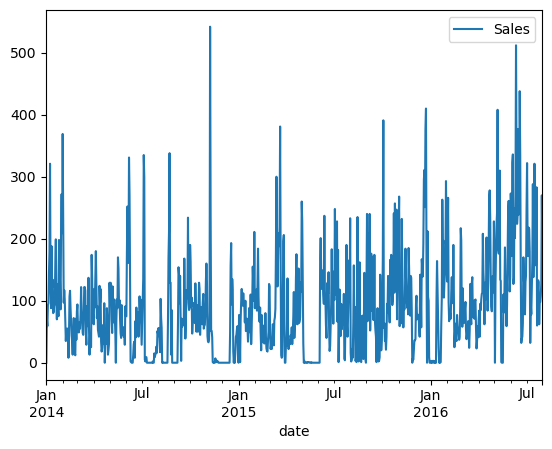

In [13]:
df.plot()

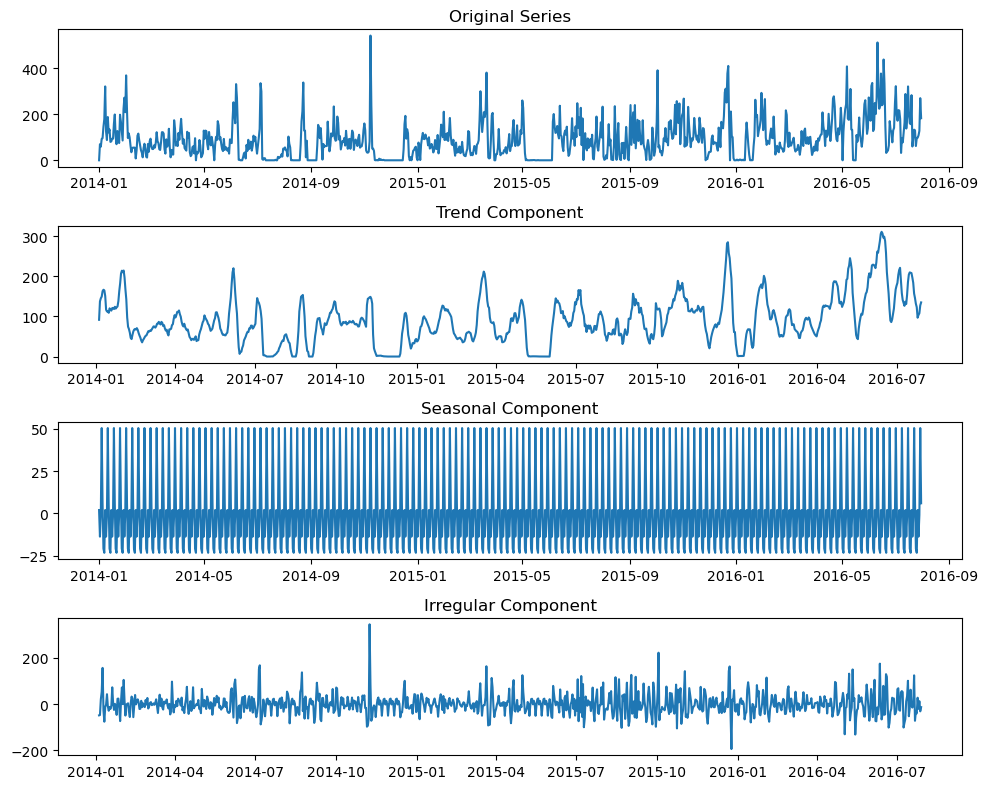

In [14]:
decomposed = seasonal_decompose(df, model = "additive")

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.set_title('Original Series')
ax1.plot(df)
ax2.set_title('Trend Component')
ax2.plot(decomposed.trend)
ax3.set_title('Seasonal Component')
ax3.plot(decomposed.seasonal)
ax4.set_title('Irregular Component')
ax4.plot(decomposed.resid)
plt.tight_layout()
plt.show()

In [15]:
print(f"Mean of residuals : {decomposed.resid.mean()}")

Mean of residuals : -0.030012206880280834


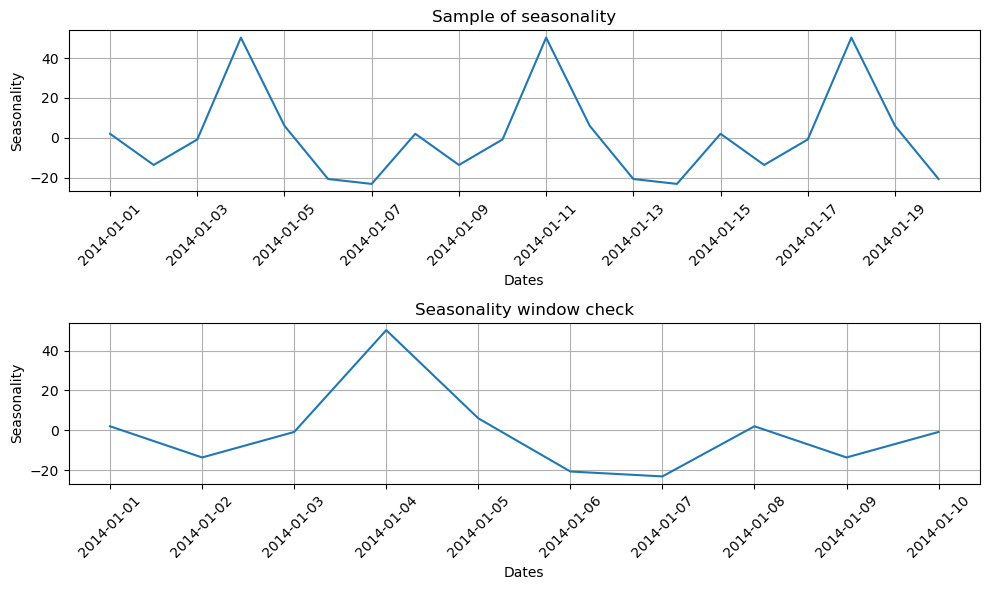

In [16]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(decomposed.seasonal[:20])
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.title('Sample of seasonality')

plt.grid()


plt.subplot(212)

plt.plot(decomposed.seasonal[:10])
plt.xticks(rotation=45)
# Add labels and title
plt.title('Seasonality window check')

plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
test_result = adfuller(df)

print(f"Test statistic :{test_result[0]}")
print(f"p-value :{test_result[1]}")

Test statistic :-4.778979266351842
p-value :5.965176191767597e-05


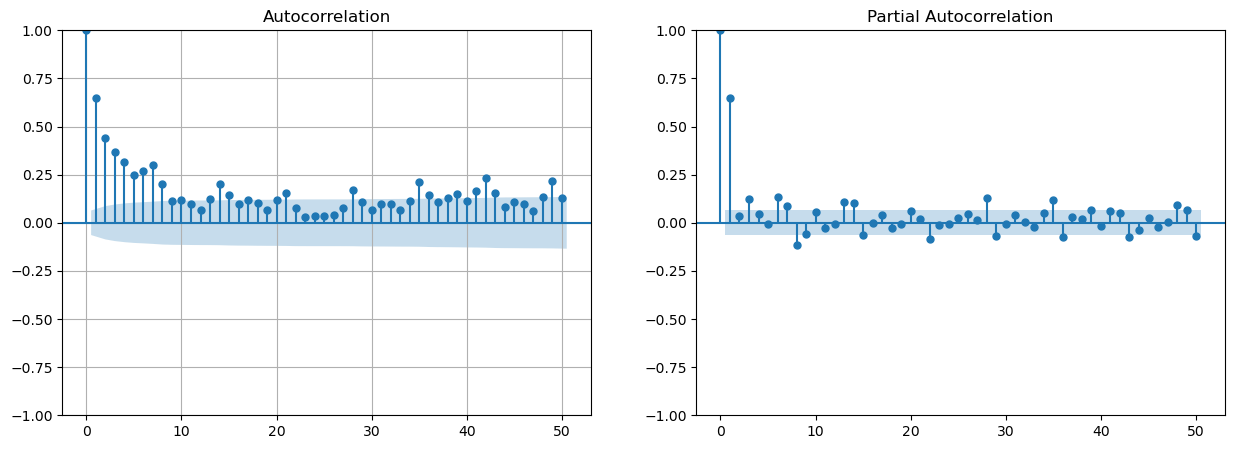

In [18]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(df,ax=plt.gca(),lags=50)
plt.grid()

plt.subplot(122)
plot_pacf(df, ax = plt.gca(), lags=50)
plt.show()

In [19]:
# Split into training and test sets (80% training, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [20]:
## Building ARIMA model for below parameters
# p = 1
# d = 0
# q = 1

arima_model = ARIMA(train, order=(1, 0, 1),enforce_stationarity=False, enforce_invertibility=False)
arima_fit = arima_model.fit()

In [21]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  754
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4124.179
Date:                Wed, 30 Jul 2025   AIC                           8256.358
Time:                        16:21:17   BIC                           8274.849
Sample:                    01-01-2014   HQIC                          8263.482
                         - 01-24-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.3821      7.934      9.879      0.000      62.831      93.933
ar.L1          0.6497      0.037     17.748      0.000       0.578       0.721
ma.L1         -0.0697      0.044     -1.578      0.1

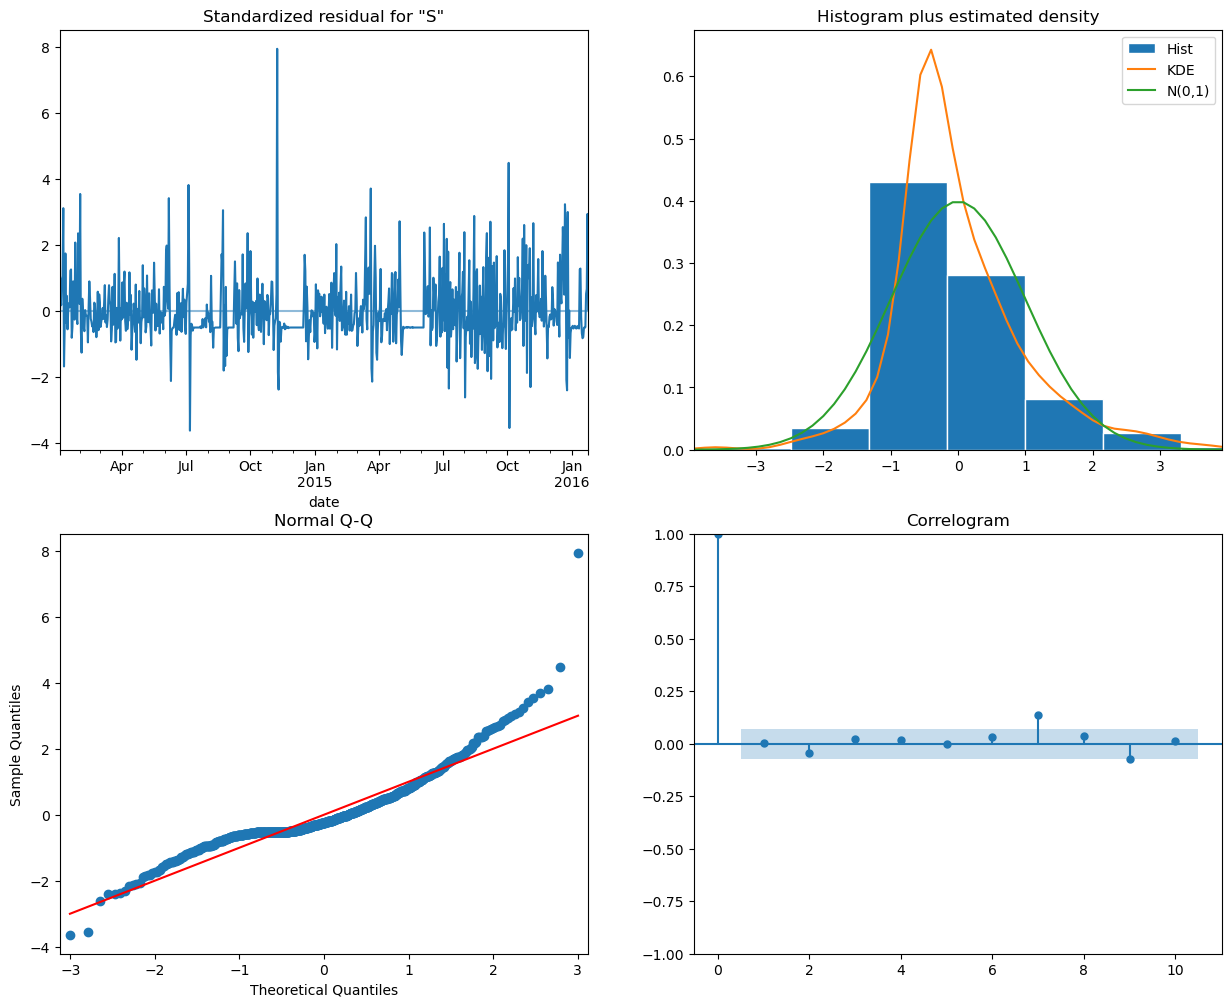

In [22]:
arima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

Mean of residuals : 0.10572315543564292


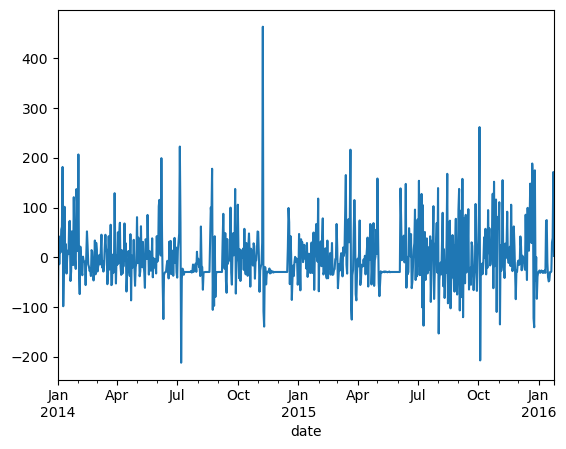

In [23]:
arima_fit.resid.plot()
print(f"Mean of residuals : {arima_fit.resid.mean()}")

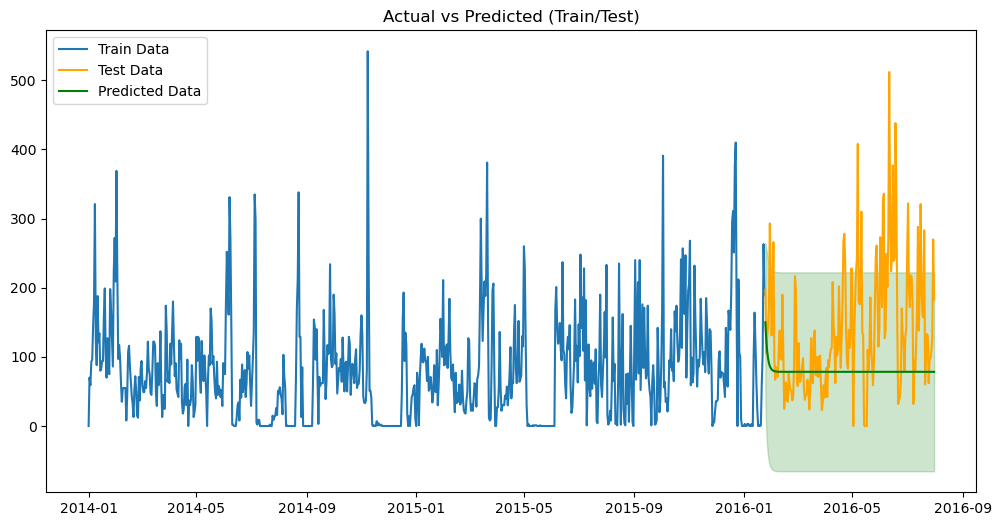

In [24]:
# Predictions on the Test Set
pred = arima_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

# Actual vs Predicted vs Test Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Predicted Data', color='green')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted (Train/Test)')
plt.show()

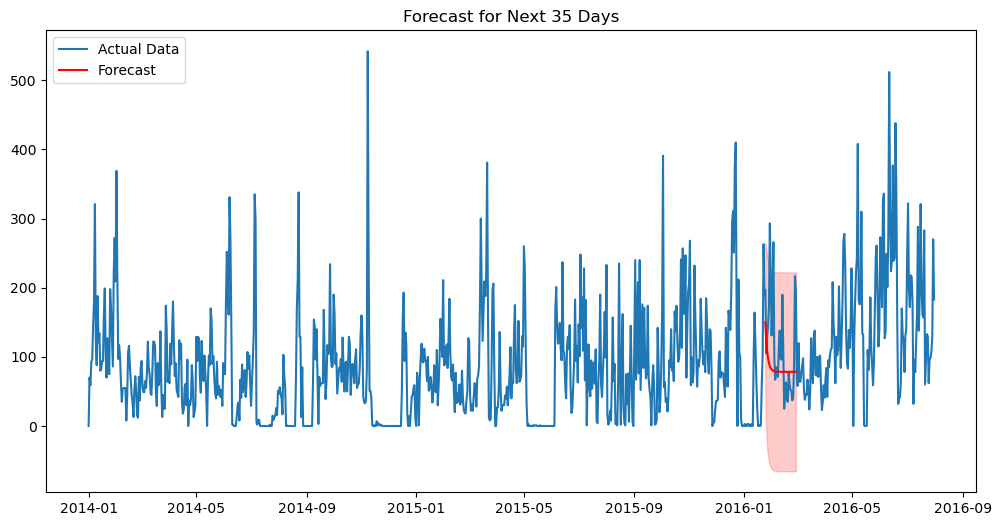

In [25]:
# Forecast for Next 35 Days
forecast = arima_fit.get_forecast(steps=35)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df, label='Actual Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='red', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Forecast for Next 35 Days')
plt.show()


In [26]:
#  Calculate RMSE for Test Set
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 107.25356854281156


In [27]:
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)


In [28]:
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  754
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -4045.987
Date:                           Wed, 30 Jul 2025   AIC                           8101.975
Time:                                   16:23:09   BIC                           8125.042
Sample:                               01-01-2014   HQIC                          8110.866
                                    - 01-24-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7146      0.029     24.618      0.000       0.658       0.771
ma.L1         -0.1254      0.041     -3.057

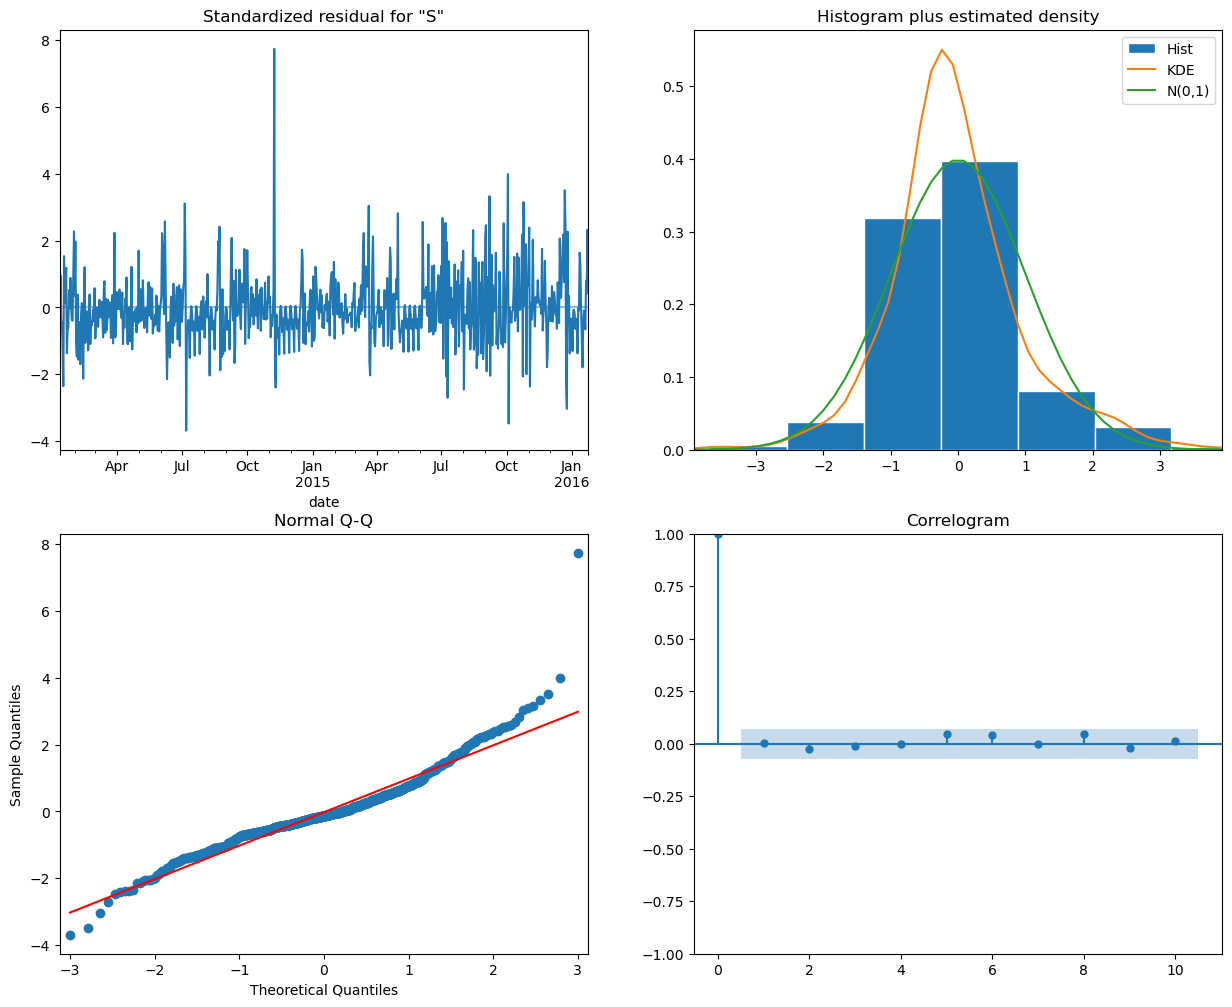

In [29]:
# Model Diagnostics
sarima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

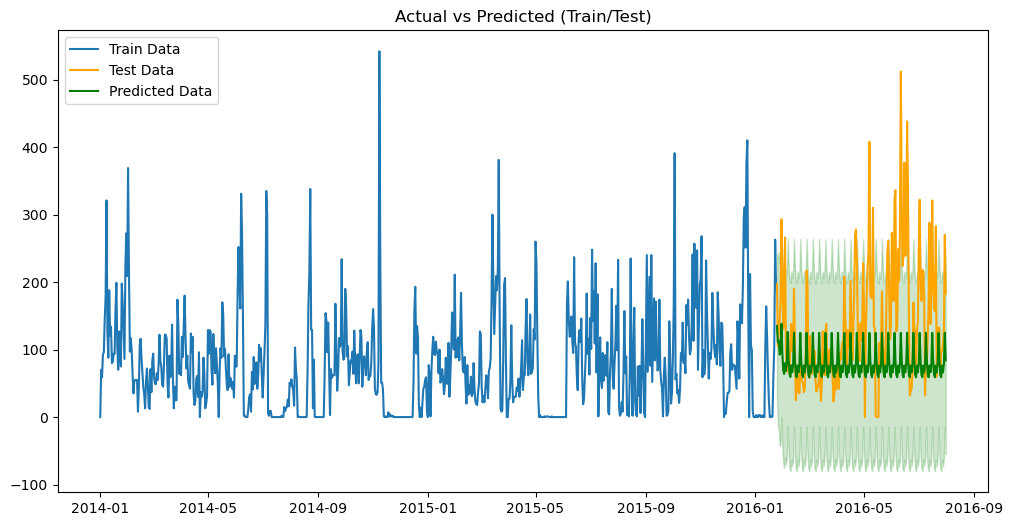

In [30]:
# Predictions on the Test Set

pred = sarima_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

#  Actual vs Predicted vs Test Plot

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Predicted Data', color='green')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted (Train/Test)')
plt.show()

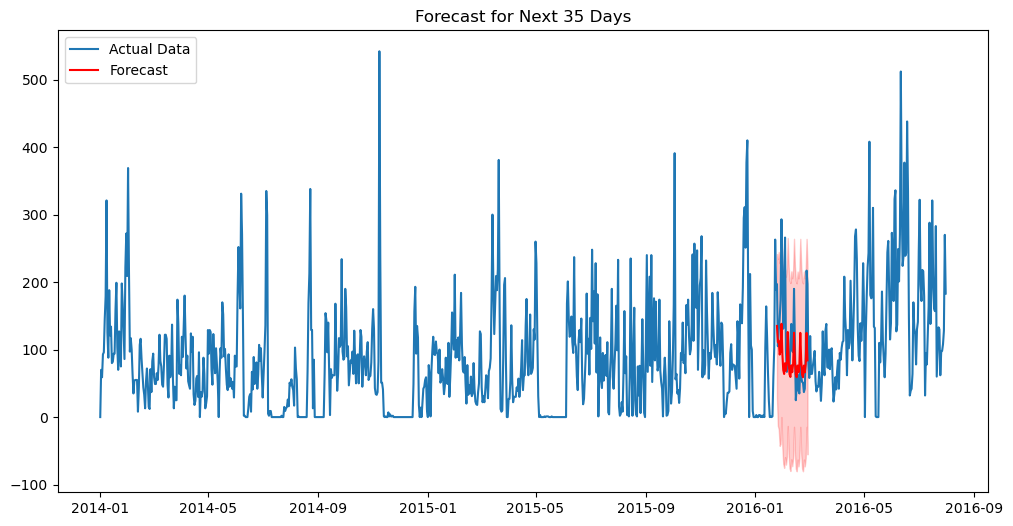

In [31]:
# Forecast for Next 35 Days
forecast = sarima_fit.get_forecast(steps=35)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df, label='Actual Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='red', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Forecast for Next 35 Days')
plt.show()


In [32]:
# Calculate RMSE for Test Set

rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 102.19724024065634


In [33]:
# Resampling for each week

df = df.resample('W').sum()

In [34]:
df.head()

,Sales
date,
2014-01-05,318.0
2014-01-12,1167.0
2014-01-19,842.0
2014-01-26,838.0
2014-02-02,1500.0


<Axes: xlabel='date'>

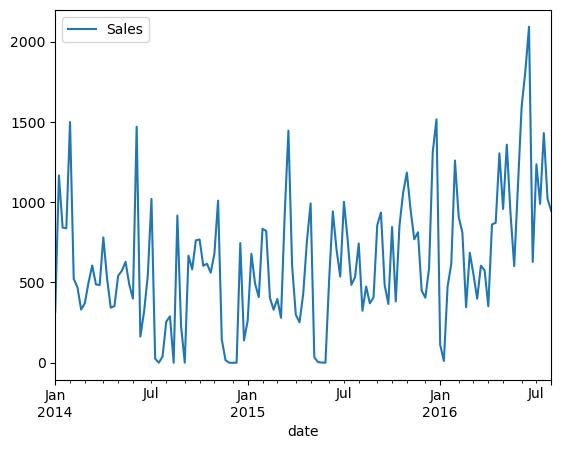

In [35]:
df.plot()

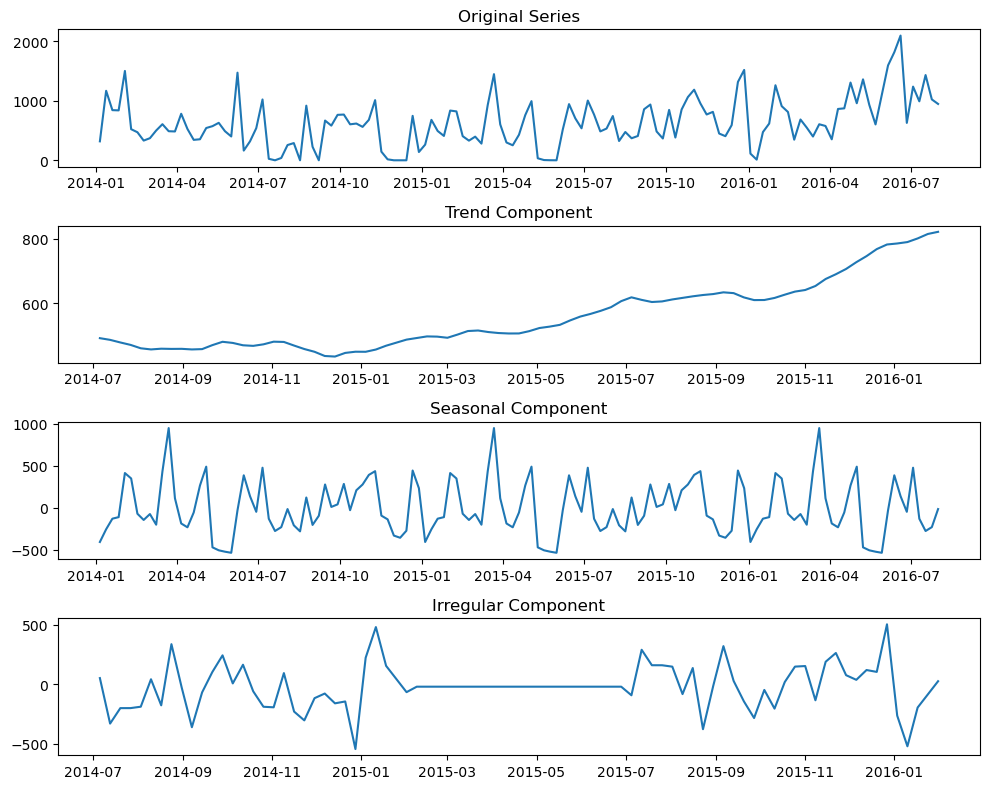

In [36]:
decomposed = seasonal_decompose(df, model = "additive")

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.set_title('Original Series')
ax1.plot(df)
ax2.set_title('Trend Component')
ax2.plot(decomposed.trend)
ax3.set_title('Seasonal Component')
ax3.plot(decomposed.seasonal)
ax4.set_title('Irregular Component')
ax4.plot(decomposed.resid)
plt.tight_layout()
plt.show()

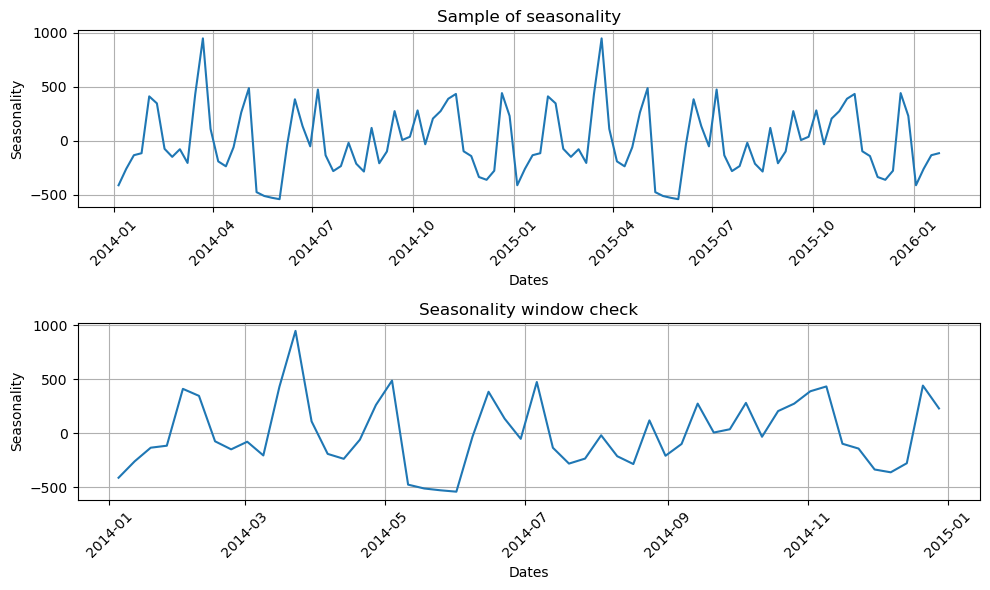

In [37]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(decomposed.seasonal[:108])
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.title('Sample of seasonality')

plt.grid()


plt.subplot(212)

plt.plot(decomposed.seasonal[:52])
plt.xticks(rotation=45)
# Add labels and title
plt.title('Seasonality window check')

plt.xlabel('Dates')
plt.ylabel('Seasonality')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
test_result = adfuller(df)

print(f"Test statistic :{test_result[0]}")
print(f"p-value :{test_result[1]}")


Test statistic :-2.3786313161828847
p-value :0.14785860790405175


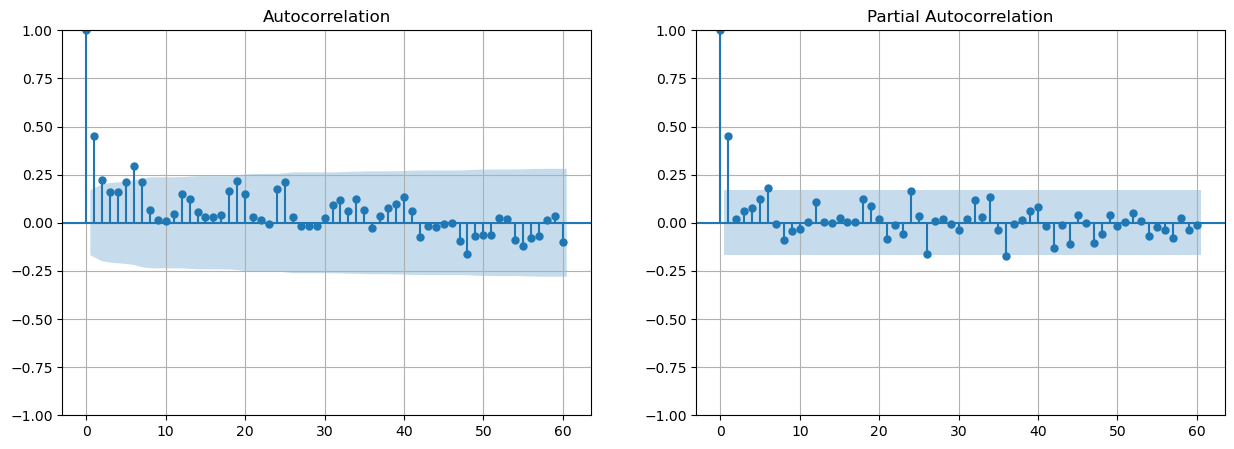

In [39]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(df,ax=plt.gca(),lags=60)
plt.grid()

plt.subplot(122)
plot_pacf(df, ax = plt.gca(), lags=60)
plt.grid()

plt.show()

In [40]:
# Split into training and test sets (80% training, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [45]:
#  parameters
p = 1   # AR order
d = 1    # Differencing order
q = 1    # MA order
P = 1    # Seasonal AR order
D = 1    # Seasonal differencing order
Q = 1    # Seasonal MA order
s = 52   # Seasonal period 

sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))

In [42]:

start_params = [0.5] * p + [0.5] * q + [0.5] * P + [0.5] * Q + [1] * (P + Q)  # Adjust as needed
# Fit the model
try:
    sarima_fit = sarima_model.fit()  # Suppress output
    print(sarima_fit.summary())
except ValueError as e:
    print("Error fitting model:", e)

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -413.776
Date:                            Wed, 30 Jul 2025   AIC                            837.552
Time:                                    16:27:20   BIC                            847.589
Sample:                                01-05-2014   HQIC                           841.433
                                     - 01-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3709      0.265      1.402      0.161      -0.148       0.889
ma.L1         -0.9476      0.125   

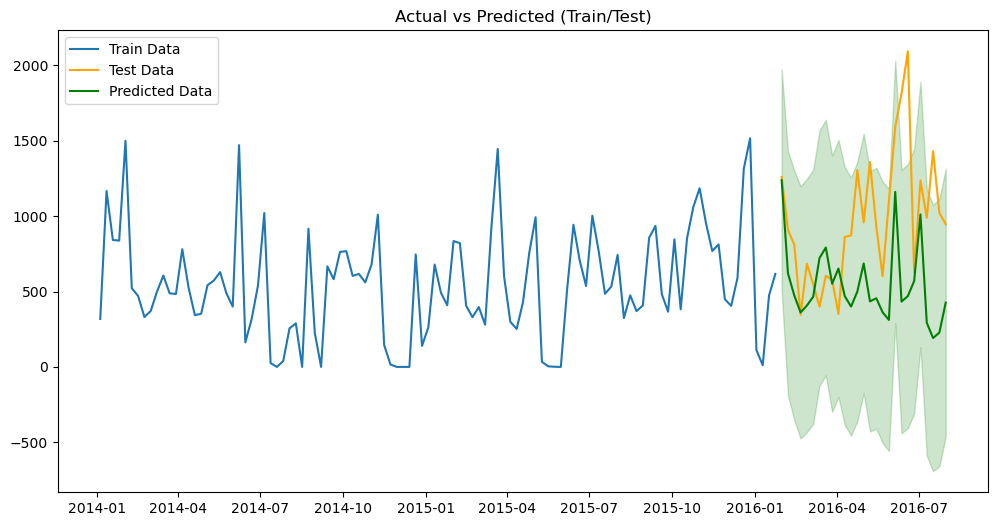

In [44]:
#  Predictions on the Test Set
pred = sarima_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

#  Actual vs Predicted vs Test Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Predicted Data', color='green')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted (Train/Test)')
plt.show()

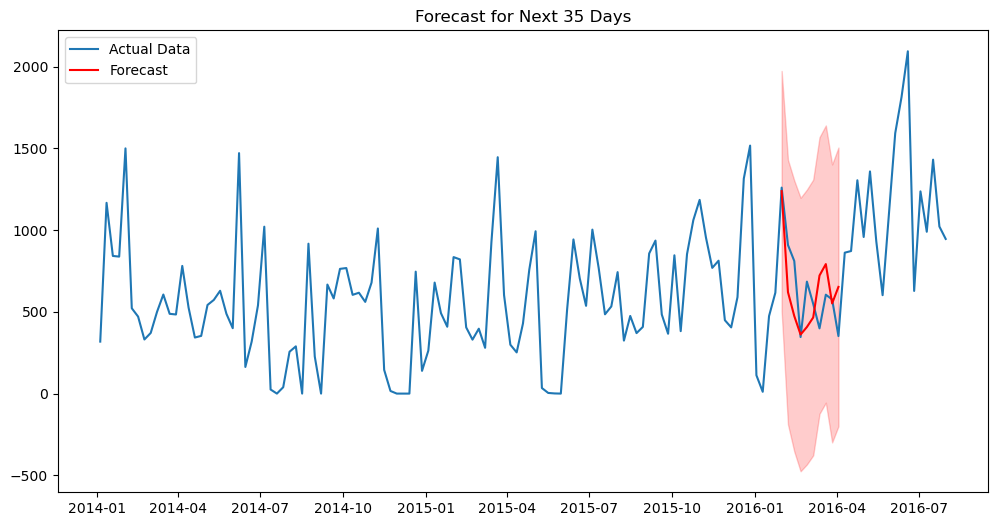

In [46]:
# Forecast for Next 35 Days
forecast = sarima_fit.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

# Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df, label='Actual Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='red', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Forecast for Next 35 Days')
plt.show()

In [47]:
#  Calculate RMSE for Test Set
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 640.3503914271324


## Conclusion
Resampling daily retail sales data into weekly intervals significantly improves forecast performance. Weekly data reveals a clearer trend and seasonal pattern, which are often obscured in daily observations due to noise and fluctuations.

The trend indicates a realistic upward trajectory in sales, reflecting consistent business growth.

Seasonality becomes more apparent in the weekly data, with recurring peaks and troughs across years—likely influenced by festive seasons, holidays, and other calendar-driven consumer behaviors.

Compared to the daily forecast model, which produced flat or inconsistent predictions, the weekly model captured these underlying patterns more effectively and yielded more reliable forecasts.

Furthermore, to support inventory planning, a simple linear regression model can be trained between predicted sales and stock levels, enabling accurate estimation of required stock for upcoming weeks. This makes the forecasting model not only more accurate but also more actionable for real-world retail operations.